# Fashion Classification (using pytorch)

## Information
- blog : https://yscho03.tistory.com/47

## Setup

In [1]:
import os
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random 

import torch
import torch.nn as nn
from torch import optim, cuda
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from torchsummary import summary

## Load Dataset

In [2]:
BASE_DIR = os.getcwd()
DATASET_PATH = os.path.join(BASE_DIR, 'dataset')
MODE_PATH = os.path.join(BASE_DIR, 'models')

In [3]:
classes = []
dataset = []

for fullpath, dirnames, filenames in os.walk(DATASET_PATH):
    if DATASET_PATH == fullpath:
        classes = dirnames
        continue        
        
    label_name = fullpath.split(os.path.sep)[-1]        
    for filename in filenames:    
        if filename.find('.npy') != -1:
            continue
        class_index = classes.index(label_name)
        dataset.append((os.path.join(fullpath, filename), class_index))

In [4]:
random.shuffle(dataset) 
dataset = dataset[:6000]
len(dataset)

6000

In [5]:
total_len = len(dataset)
train_ratio = int(total_len * 0.8)

train_data = dataset[:train_ratio]
test_data = dataset[train_ratio:]

In [6]:
class Dataset(object):
    def __init__(self, transforms, dataset):
        self.transforms = transforms
        self.dataset = dataset

    def __getitem__(self, idx):
        img_path, label = self.dataset[idx]        
        
        fullpath, extension = os.path.splitext(img_path)
        npy_path = fullpath + '.npy'
        
        if os.path.exists(npy_path):
            np_data = np.load(npy_path)
            img = Image.fromarray(np.uint8(np_data))
        else:
            img = Image.open(img_path).convert("RGB")  
            np_data = np.asarray(img)
            np.save(npy_path, np_data)
        
        if self.transforms is not None:
            img = self.transforms(img)                
        return img, label

    def __len__(self): 
        return len(self.dataset)

In [7]:
transform = transforms.Compose(
    [
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [8]:
train_dataset = Dataset(transform, train_data)
test_dataset = Dataset(transform, test_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5)

## Visualize the data

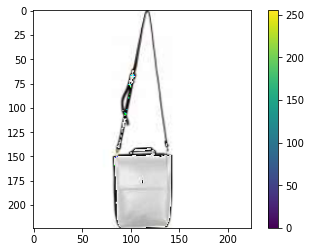

In [9]:
dataloader = iter(train_loader)
imgs, target = dataloader.next()

tf = transforms.ToPILImage()
pil_img = tf(imgs[0])
plt.figure()
plt.imshow(pil_img)
plt.colorbar()
plt.gca().grid(False)

In [10]:
learning_rate = 0.001
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
device

device(type='cuda')

## Build Model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(            
            nn.Conv2d(3, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
        self.avg_pool = nn.AvgPool2d(7)
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        features = self.conv(x)
        x = self.avg_pool(features)
        x = x.view(features.size(0), -1)
        x = self.classifier(x)
        return x, features

In [12]:
model = Net().to(device)
model

Net(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.2)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): LeakyReLU(negative_slop

In [13]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
summary(model.to(device), (3, 224, 224))

D:\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
         LeakyReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
         LeakyReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
         LeakyReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
         LeakyReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
        LeakyReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
        LeakyReLU-14          [-1, 256,

## Training

In [15]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [16]:
writer = SummaryWriter('runs/fashion_classification')

In [17]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [18]:
def images_to_probs(model, images):
    output,f  = model(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [nn.functional.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [19]:
def plot_classes_preds(model, images, labels):
    preds, probs = images_to_probs(model, images)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):        
        if len(images) - 1 < idx:
            break        
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]), color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [20]:
def train_model(model, n_epochs):

    train_losses = []
    valid_losses = []
    early_stopping = EarlyStopping(verbose = True)

    for epoch in range(n_epochs):

        epoch_loss = 0
        start = time.time()
        model.train()
        for batch, (data, target) in enumerate(train_loader, 1):    
            
            data = data.to(device)
            target = target.to(device)
            
            output, f = model(data)
            loss = criterion(output, target)
            
            optimizer.zero_grad()   
            loss.backward()
            optimizer.step()
            epoch_loss += loss
            
            if batch % 100 == 0:
                writer.add_scalar('training loss', epoch_loss / 100, epoch * len(train_loader) + batch)
                writer.add_figure('predictions vs. actuals', plot_classes_preds(model, data, target), global_step=epoch * len(train_loader) + batch)                        
        print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')
            
        model.eval() 
        for data, target in test_loader :
            
            data = data.to(device)
            target = target.to(device)            
            
            output, f = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)

        epoch_len = len(str(n_epochs))      
        train_losses = []
        valid_losses = []
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break


In [21]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [23]:
n_epochs = 50
train_model(model, n_epochs)  

Validation loss decreased (inf --> 0.414573).  Saving model ...


D:\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
D:\anaconda3\envs\pytorch\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Inference

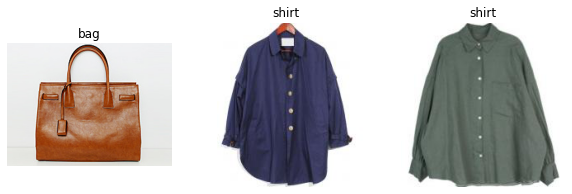

In [24]:
columns = 3
rows = 1
fig = plt.figure(figsize=(10,10))
 
model.eval()
for i in range(1, columns*rows+1):
    idx = np.random.randint(len(test_data))
    img_path, class_index = test_data[idx]
    pil_img = Image.open(img_path).convert('RGB')
    img = transform(pil_img).unsqueeze(dim=0).to(device)    
    output,f  = model(img)
    _, argmax = torch.max(output, 1)
    pred = classes[argmax.item()]
    label = classes[class_index]
    
    fig.add_subplot(rows, columns, i)
    plt.title(pred)    
    plt.imshow(pil_img)
    plt.axis('off')
    
plt.show() 